<a href="https://colab.research.google.com/github/KothaiKumar/-Implementation-of-Logistic-Regression-Using-Gradient-Descent/blob/main/DLEXP6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [10]:
data.head(50)
data = data.fillna(method="ffill")
data.head(50)


<ipython-input-10-13da59a30ca5>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [11]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())




Unique words in corpus: 26554
Unique tags in corpus: 17


In [12]:
words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())



In [13]:

print("Unique tags are:", tags)


Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [14]:
num_words = len(words)
num_tags = len(tags)

In [15]:
num_words

26555

In [17]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [18]:
getter = SentenceGetter(data)
sentences = getter.sentences


In [19]:
len(sentences)

26469

In [20]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [21]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


In [22]:
word2idx

{'Thousands': 1,
 'of': 2,
 'demonstrators': 3,
 'have': 4,
 'marched': 5,
 'through': 6,
 'London': 7,
 'to': 8,
 'protest': 9,
 'the': 10,
 'war': 11,
 'in': 12,
 'Iraq': 13,
 'and': 14,
 'demand': 15,
 'withdrawal': 16,
 'British': 17,
 'troops': 18,
 'from': 19,
 'that': 20,
 'country': 21,
 '.': 22,
 'Families': 23,
 'soldiers': 24,
 'killed': 25,
 'conflict': 26,
 'joined': 27,
 'protesters': 28,
 'who': 29,
 'carried': 30,
 'banners': 31,
 'with': 32,
 'such': 33,
 'slogans': 34,
 'as': 35,
 '"': 36,
 'Bush': 37,
 'Number': 38,
 'One': 39,
 'Terrorist': 40,
 'Stop': 41,
 'Bombings': 42,
 'They': 43,
 'Houses': 44,
 'Parliament': 45,
 'a': 46,
 'rally': 47,
 'Hyde': 48,
 'Park': 49,
 'Police': 50,
 'put': 51,
 'number': 52,
 'marchers': 53,
 'at': 54,
 '10,000': 55,
 'while': 56,
 'organizers': 57,
 'claimed': 58,
 'it': 59,
 'was': 60,
 '1,00,000': 61,
 'The': 62,
 'comes': 63,
 'on': 64,
 'eve': 65,
 'annual': 66,
 'conference': 67,
 'Britain': 68,
 "'s": 69,
 'ruling': 70,
 'L

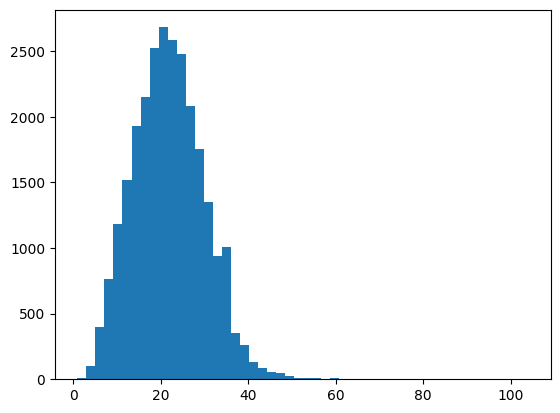

In [23]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()


In [24]:
X1 = [[word2idx[w[0]] for w in s] for s in sentences]

In [25]:

type(X1[0])

list

In [26]:
X1[0]
max_len = 50
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)

X[0]
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)
X_train[0]
y_train[0]


array([ 0,  0,  3, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [28]:

input_word = layers.Input(shape=(max_len,))
embedding_layer = layers.Embedding(input_dim=num_words,
                         output_dim=50,
                         input_length=max_len)(input_word)
dropout_layer = layers.SpatialDropout1D(0.1)(embedding_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(units=100,
                                  return_sequences=True,
                                  recurrent_dropout=0.1))(dropout_layer)
output=layers.TimeDistributed(layers.Dense(num_tags, activation="softmax"))(bi_lstm)
model = Model(input_word, output)




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
print('Name: Kothai K  Register Number: 212222240051    ')
model.summary()




Name: Kothai K  Register Number: 212222240051    


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 50, 50)              │       1,327,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,451,967 (5.54 MB)

 Trainable params: 1,451,967 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])




In [32]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=3,
)



Epoch 1/3
662/662 ━━━━━━━━━━━━━━━━━━━━ 104s 140ms/step - accuracy: 0.9281 - loss: 0.4122 - val_accuracy: 0.9727 - val_loss: 0.0959
Epoch 2/3
662/662 ━━━━━━━━━━━━━━━━━━━━ 83s 125ms/step - accuracy: 0.9780 - loss: 0.0772 - val_accuracy: 0.9823 - val_loss: 0.0595
Epoch 3/3
662/662 ━━━━━━━━━━━━━━━━━━━━ 142s 126ms/step - accuracy: 0.9861 - loss: 0.0478 - val_accuracy: 0.9844 - val_loss: 0.0523


In [33]:

metrics = pd.DataFrame(model.history.history)
metrics.head()



,accuracy,loss,val_accuracy,val_loss
0,0.949250,0.217802,0.972720,0.095861
1,0.980345,0.068928,0.982293,0.059544
2,0.986616,0.045739,0.984364,0.052265


Name: Kothai K  Register Number: 212222240051    


<Axes: >

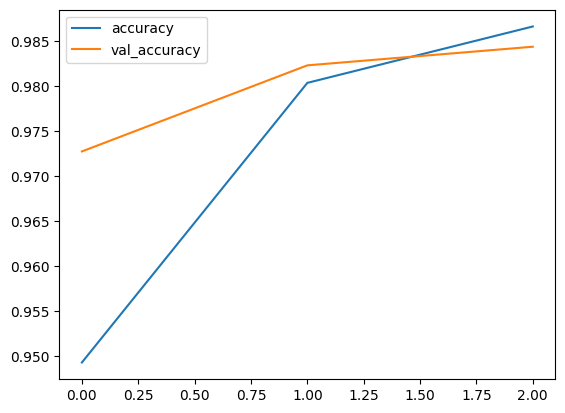

In [36]:

print('Name: Kothai K  Register Number: 212222240051    ')
metrics[['accuracy','val_accuracy']].plot()



Name: Kothai K  Register Number: 212222240051    


<Axes: >

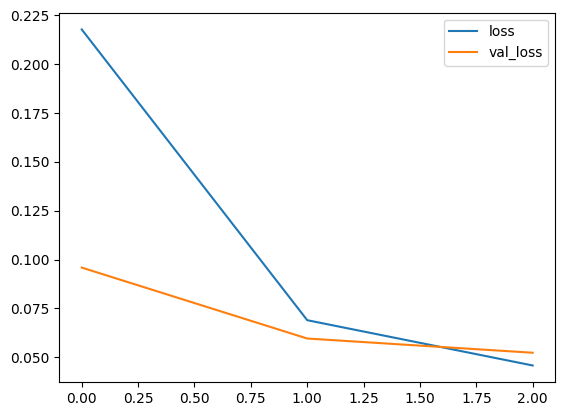

In [37]:
print('Name: Kothai K  Register Number: 212222240051    ')
metrics[['loss','val_loss']].plot()

In [35]:

i = 20
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print('Name: Kothai K  Register Number: 212222240051    ')
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
Name: Kothai K  Register Number: 212222240051    
Word           True 	 Pred

------------------------------
News           O	O
reports        O	O
Saturday       B-tim	B-tim
quote          O	O
an             O	O
unnamed        O	O
Iranian        B-gpe	B-gpe
official       O	O
as             O	O
saying         O	O
a              O	O
delegation     O	O
will           O	O
visit          O	O
on             O	O
August         B-tim	B-tim
6              I-tim	I-tim
to             O	O
discuss        O	O
technical      O	O
issues         O	O
and            O	O
regulations    O	O
.              O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Chepas         O	O
Che